# LMDB 数据库完整教程

本教程将教你如何从零开始使用 LMDB（Lightning Memory-Mapped Database）。我们将按照以下顺序学习：

1. **创建数据库** - 如何创建新的 LMDB 数据库
2. **写入数据** - 如何向数据库中写入数据
3. **键值关联** - 如何设置键值对的关联关系
4. **读取数据** - 如何从数据库中读取数据
5. **数据管理** - 如何更新和删除数据

## 什么是 LMDB？

LMDB 是一个快速、轻量级的键值数据库，特别适合：
- 大规模数据存储
- 高速随机读写
- 内存映射访问
- 多进程并发访问

## 教程数据说明

在本教程中，我们将创建一个包含电池测试数据的 LMDB 数据库，包含：
- 不同类型的电池测试步骤
- 时间序列数据（时间、电流、电压）
- 元数据信息
- 键值对关联结构

## 1. 导入必要的库

In [1]:
import lmdb
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from collections import Counter
import random
from tqdm import tqdm
import datetime

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 定义教程数据库路径（使用绝对路径）
TUTORIAL_DB_PATH = 'tutorial_battery_data.lmdb'

print(f"教程数据库路径: {TUTORIAL_DB_PATH}")
print(f"教程文件夹: {os.path.dirname(TUTORIAL_DB_PATH)}")

教程数据库路径: tutorial_battery_data.lmdb
教程文件夹: 


## 2. 创建新的 LMDB 数据库

学习如何创建一个新的 LMDB 数据库。

In [2]:
# 如果数据库已存在，先删除它
if os.path.exists(TUTORIAL_DB_PATH):
    import shutil
    shutil.rmtree(TUTORIAL_DB_PATH)
    print(f"已删除现有数据库: {TUTORIAL_DB_PATH}")

# 创建新的 LMDB 数据库
# map_size: 数据库的最大大小（字节）
# readonly: 是否只读模式
# max_dbs: 最大数据库数量
env = lmdb.open(TUTORIAL_DB_PATH, 
               map_size=1024*1024*1024,  # 1GB
               readonly=False,
               max_dbs=1)

print(f"成功创建数据库: {TUTORIAL_DB_PATH}")
print(f"数据库最大大小: {1024*1024*1024 / (1024*1024)} MB")
print(f"数据库模式: 读写模式")

已删除现有数据库: tutorial_battery_data.lmdb
成功创建数据库: tutorial_battery_data.lmdb
数据库最大大小: 1024.0 MB
数据库模式: 读写模式


## 3. 生成示例数据

首先生成一些示例的电池测试数据，用于演示写入操作。

In [3]:
# 定义电池测试步骤类型
STEP_TYPES = {
    'CC_Chg': '恒流充电',
    'CC_DChg': '恒流放电', 
    'CV_Chg': '恒压充电',
    'CCCV_Chg': '恒流恒压充电',
    'CP_Chg': '恒功率充电',
    'CP_DChg': '恒功率放电',
    'Rest': '搁置'
}

def generate_battery_step_data(step_type, dataset_id, step_id, duration=3600):
    """生成电池测试步骤数据"""
    
    # 生成时间序列（采样频率：1Hz）
    num_points = duration  # 1小时的数据
    t_data = np.linspace(0, duration, num_points)
    
    # 根据步骤类型生成不同的电流和电压曲线
    if step_type == 'CC_Chg':
        # 恒流充电：电流恒定，电压逐渐上升
        i_data = np.full(num_points, 1.0) + np.random.normal(0, 0.01, num_points)
        v_data = 3.0 + 0.5 * (t_data / duration) + np.random.normal(0, 0.01, num_points)
    elif step_type == 'CC_DChg':
        # 恒流放电：电流恒定（负值），电压逐渐下降
        i_data = np.full(num_points, -1.0) + np.random.normal(0, 0.01, num_points)
        v_data = 4.0 - 0.5 * (t_data / duration) + np.random.normal(0, 0.01, num_points)
    elif step_type == 'CV_Chg':
        # 恒压充电：电压恒定，电流逐渐减小
        v_data = np.full(num_points, 4.2) + np.random.normal(0, 0.01, num_points)
        i_data = 1.0 * np.exp(-t_data / (duration/3)) + np.random.normal(0, 0.01, num_points)
    elif step_type == 'CCCV_Chg':
        # 恒流恒压充电：前半段恒流，后半段恒压
        halfway = num_points // 2
        i_data = np.concatenate([
            np.full(halfway, 1.0),
            1.0 * np.exp(-(t_data[halfway:] - t_data[halfway]) / (duration/6))
        ]) + np.random.normal(0, 0.01, num_points)
        v_data = np.concatenate([
            3.0 + 1.2 * (t_data[:halfway] / t_data[halfway]),
            np.full(num_points - halfway, 4.2)
        ]) + np.random.normal(0, 0.01, num_points)
    elif step_type in ['CP_Chg', 'CP_DChg']:
        # 恒功率充电/放电：功率恒定，电流和电压相互关联
        power = 4.0 if step_type == 'CP_Chg' else -4.0
        v_data = 3.5 + 0.5 * np.sin(2 * np.pi * t_data / duration) + np.random.normal(0, 0.01, num_points)
        i_data = power / v_data + np.random.normal(0, 0.01, num_points)
    else:  # Rest
        # 搁置：电流为0，电压缓慢变化
        i_data = np.random.normal(0, 0.001, num_points)
        v_data = 3.8 + 0.1 * np.sin(2 * np.pi * t_data / (duration*2)) + np.random.normal(0, 0.01, num_points)
    
    # 创建数据记录
    data_record = {
        'step_name': step_type,
        'dataset_base_name': f"{step_type}_dataset_{dataset_id}_step{step_id:04d}",
        't_data': t_data,
        'i_data': i_data,
        'v_data': v_data,
        'metadata': {
            'step_type': STEP_TYPES[step_type],
            'dataset_id': dataset_id,
            'step_id': step_id,
            'duration': duration,
            'num_points': num_points,
            'created_at': datetime.datetime.now().isoformat()
        }
    }
    
    return data_record

# 生成示例数据
print("正在生成示例数据...")
sample_data = []

# 为每种步骤类型生成3个数据集，每个数据集5个步骤
for step_type in STEP_TYPES.keys():
    for dataset_id in range(1, 4):  # 3个数据集
        for step_id in range(1, 6):  # 5个步骤
            # 随机生成持续时间（30分钟到2小时）
            duration = random.randint(1800, 7200)
            data = generate_battery_step_data(step_type, dataset_id, step_id, duration)
            sample_data.append(data)

print(f"生成了 {len(sample_data)} 条示例数据")
print(f"步骤类型: {list(STEP_TYPES.keys())}")
print(f"每种类型的数据集数量: 3")
print(f"每个数据集的步骤数量: 5")

正在生成示例数据...
生成了 105 条示例数据
步骤类型: ['CC_Chg', 'CC_DChg', 'CV_Chg', 'CCCV_Chg', 'CP_Chg', 'CP_DChg', 'Rest']
每种类型的数据集数量: 3
每个数据集的步骤数量: 5


## 4. 设计键值关联结构

学习如何设计合理的键值关联结构。键的设计原则：
- 唯一性：每个键必须是唯一的
- 可排序性：键可以按字典序排序
- 层次性：可以表达数据的层次关系
- 可查询性：支持前缀查询和范围查询

In [4]:
def create_key_structure(data_record):
    """创建键值结构
    
    键的格式：step_type/dataset_id/step_id
    例如：CC_Chg/001/0001
    
    这种结构的优点：
    1. 可以按步骤类型查询
    2. 可以按数据集查询
    3. 可以按步骤ID查询
    4. 支持范围查询
    """
    step_type = data_record['step_name']
    dataset_id = data_record['metadata']['dataset_id']
    step_id = data_record['metadata']['step_id']
    
    # 构建分层键
    key = f"{step_type}/{dataset_id:03d}/{step_id:04d}"
    
    return key

def create_alternative_key_structure(data_record):
    """创建备用键值结构
    
    键的格式：dataset_id/step_id/step_type
    例如：001/0001/CC_Chg
    
    这种结构适合按数据集为主要查询维度的场景
    """
    step_type = data_record['step_name']
    dataset_id = data_record['metadata']['dataset_id']
    step_id = data_record['metadata']['step_id']
    
    key = f"{dataset_id:03d}/{step_id:04d}/{step_type}"
    
    return key

# 演示不同的键结构
sample_record = sample_data[0]
key1 = create_key_structure(sample_record)
key2 = create_alternative_key_structure(sample_record)

print("键值结构设计示例:")
print(f"原始数据: {sample_record['step_name']} - 数据集{sample_record['metadata']['dataset_id']} - 步骤{sample_record['metadata']['step_id']}")
print(f"主要键结构: {key1}")
print(f"备用键结构: {key2}")

# 展示所有键的示例
print("\n所有键的示例 (前10个):")
for i, data in enumerate(sample_data[:10]):
    key = create_key_structure(data)
    print(f"  {i+1:2d}. {key} -> {data['metadata']['step_type']}")

键值结构设计示例:
原始数据: CC_Chg - 数据集1 - 步骤1
主要键结构: CC_Chg/001/0001
备用键结构: 001/0001/CC_Chg

所有键的示例 (前10个):
   1. CC_Chg/001/0001 -> 恒流充电
   2. CC_Chg/001/0002 -> 恒流充电
   3. CC_Chg/001/0003 -> 恒流充电
   4. CC_Chg/001/0004 -> 恒流充电
   5. CC_Chg/001/0005 -> 恒流充电
   6. CC_Chg/002/0001 -> 恒流充电
   7. CC_Chg/002/0002 -> 恒流充电
   8. CC_Chg/002/0003 -> 恒流充电
   9. CC_Chg/002/0004 -> 恒流充电
  10. CC_Chg/002/0005 -> 恒流充电


## 5. 写入数据到 LMDB 数据库

学习如何使用事务将数据写入 LMDB 数据库。

In [5]:
# 写入数据到数据库
print("开始写入数据到数据库...")

# 使用写事务
with env.begin(write=True) as txn:
    write_count = 0
    
    for data_record in tqdm(sample_data, desc="写入数据"):
        # 创建键
        key = create_key_structure(data_record)
        
        # 序列化数据
        serialized_data = pickle.dumps(data_record)
        
        # 写入数据库
        # key 和 value 都必须是字节类型
        success = txn.put(key.encode('utf-8'), serialized_data)
        
        if success:
            write_count += 1
        else:
            print(f"写入失败: {key}")

print(f"\n成功写入 {write_count} 条记录")
print(f"数据库文件位置: {TUTORIAL_DB_PATH}")

# 验证写入结果
with env.begin() as txn:
    stat = txn.stat()
    print(f"\n数据库统计信息:")
    print(f"  总记录数: {stat['entries']:,}")
    print(f"  页面大小: {stat['psize']:,} bytes")
    print(f"  数据库深度: {stat['depth']}")

开始写入数据到数据库...


写入数据: 100%|██████████| 105/105 [00:00<00:00, 24726.40it/s]


成功写入 105 条记录
数据库文件位置: tutorial_battery_data.lmdb

数据库统计信息:
  总记录数: 105
  页面大小: 4,096 bytes
  数据库深度: 1


## 6. 批量写入和事务管理

学习如何进行批量写入和事务管理，提高写入效率。

In [6]:
def batch_write_to_lmdb(env, data_list, batch_size=1000):
    """批量写入数据到 LMDB
    
    Args:
        env: LMDB 环境对象
        data_list: 要写入的数据列表
        batch_size: 批量大小
    """
    total_written = 0
    
    for i in range(0, len(data_list), batch_size):
        batch = data_list[i:i+batch_size]
        
        # 开始一个写事务
        with env.begin(write=True) as txn:
            batch_written = 0
            
            for data_record in batch:
                try:
                    # 创建键
                    key = create_key_structure(data_record)
                    
                    # 序列化数据
                    serialized_data = pickle.dumps(data_record)
                    
                    # 写入数据库
                    success = txn.put(key.encode('utf-8'), serialized_data)
                    
                    if success:
                        batch_written += 1
                    else:
                        print(f"写入失败: {key}")
                        
                except Exception as e:
                    print(f"写入错误: {e}")
                    # 事务会自动回滚
                    break
            
            total_written += batch_written
            print(f"批次 {i//batch_size + 1}: 写入 {batch_written} 条记录")
    
    return total_written

# 生成更多数据进行批量写入演示
print("生成更多数据进行批量写入演示...")
additional_data = []

# 生成额外的数据
for step_type in ['CC_Chg', 'CC_DChg', 'Rest']:
    for dataset_id in range(4, 7):  # 数据集4-6
        for step_id in range(1, 11):  # 步骤1-10
            duration = random.randint(1800, 7200)
            data = generate_battery_step_data(step_type, dataset_id, step_id, duration)
            additional_data.append(data)

print(f"生成了 {len(additional_data)} 条额外数据")

# 批量写入
written_count = batch_write_to_lmdb(env, additional_data, batch_size=50)
print(f"\n批量写入完成，总共写入 {written_count} 条记录")

# 查看最终的数据库状态
with env.begin() as txn:
    stat = txn.stat()
    print(f"\n最终数据库统计信息:")
    print(f"  总记录数: {stat['entries']:,}")
    print(f"  数据库大小: {stat['psize'] * stat['leaf_pages'] / 1024 / 1024:.2f} MB")

生成更多数据进行批量写入演示...
生成了 90 条额外数据
批次 1: 写入 50 条记录
批次 2: 写入 40 条记录

批量写入完成，总共写入 90 条记录

最终数据库统计信息:
  总记录数: 195
  数据库大小: 0.01 MB


## 7. 基础数据读取

现在我们开始学习如何从刚才创建的数据库中读取数据。

In [7]:
# 获取数据库基本信息
with env.begin() as txn:
    stat = txn.stat()
    print("数据库基本信息:")
    print(f"  总记录数: {stat['entries']:,}")
    print(f"  分支页数: {stat['branch_pages']:,}")
    print(f"  叶子页数: {stat['leaf_pages']:,}")
    print(f"  页面大小: {stat['psize']:,} bytes")
    print(f"  数据库深度: {stat['depth']}")
    
    # 获取前10个键
    cursor = txn.cursor()
    keys = []
    
    print("\n前10个键:")
    for i, (key, value) in enumerate(cursor):
        if i < 10:
            key_str = key.decode('utf-8')
            keys.append(key_str)
            print(f"  {i+1:2d}. {key_str}")
        else:
            break

数据库基本信息:
  总记录数: 195
  分支页数: 1
  叶子页数: 2
  页面大小: 4,096 bytes
  数据库深度: 2

前10个键:
   1. CCCV_Chg/001/0001
   2. CCCV_Chg/001/0002
   3. CCCV_Chg/001/0003
   4. CCCV_Chg/001/0004
   5. CCCV_Chg/001/0005
   6. CCCV_Chg/002/0001
   7. CCCV_Chg/002/0002
   8. CCCV_Chg/002/0003
   9. CCCV_Chg/002/0004
  10. CCCV_Chg/002/0005


## 8. 按键精确查找

学习如何通过键直接查找特定记录。

In [8]:
# 查找特定的键
def get_record_by_key(env, key):
    """根据键获取记录"""
    with env.begin() as txn:
        value = txn.get(key.encode('utf-8'))
        if value:
            return pickle.loads(value)
        return None

# 查找第一个记录
if keys:
    target_key = keys[0]
    record = get_record_by_key(env, target_key)
    
    if record:
        print(f"成功找到键 '{target_key}' 的数据:")
        print(f"  步骤类型: {record['step_name']} ({record['metadata']['step_type']})")
        print(f"  数据集ID: {record['metadata']['dataset_id']}")
        print(f"  步骤ID: {record['metadata']['step_id']}")
        print(f"  数据长度: {len(record['t_data'])} 个时间点")
        print(f"  持续时间: {record['metadata']['duration']} 秒")
        print(f"  创建时间: {record['metadata']['created_at']}")
        
        # 显示数据的前几个值
        print(f"\n时间序列前5个值: {record['t_data'][:5]}")
        print(f"电流序列前5个值: {record['i_data'][:5]}")
        print(f"电压序列前5个值: {record['v_data'][:5]}")
    else:
        print(f"未找到键 '{target_key}'")
else:
    print("没有可用的键进行查找")

成功找到键 'CCCV_Chg/001/0001' 的数据:
  步骤类型: CCCV_Chg (恒流恒压充电)
  数据集ID: 1
  步骤ID: 1
  数据长度: 5848 个时间点
  持续时间: 5848 秒
  创建时间: 2025-07-15T20:03:38.338087

时间序列前5个值: [0.         1.00017103 2.00034206 3.00051308 4.00068411]
电流序列前5个值: [0.99331622 0.98503376 1.00059687 1.00302035 0.98982262]
电压序列前5个值: [3.00479109 3.00630334 3.00325341 3.00456939 3.00606376]


## 9. 前缀查询和范围查询

学习如何利用键的结构进行前缀查询和范围查询。

In [9]:
def query_by_prefix(env, prefix):
    """根据前缀查询记录"""
    results = []
    
    with env.begin() as txn:
        cursor = txn.cursor()
        
        # 设置游标到前缀开始位置
        if cursor.set_range(prefix.encode('utf-8')):
            for key, value in cursor:
                key_str = key.decode('utf-8')
                
                # 检查是否仍然匹配前缀
                if key_str.startswith(prefix):
                    data = pickle.loads(value)
                    results.append((key_str, data))
                else:
                    break
    
    return results

# 查询所有CC_Chg类型的记录
print("查询所有CC_Chg类型的记录:")
cc_chg_records = query_by_prefix(env, "CC_Chg")
print(f"找到 {len(cc_chg_records)} 条CC_Chg记录")

for i, (key, data) in enumerate(cc_chg_records[:5]):
    print(f"  {i+1}. {key} -> 数据集{data['metadata']['dataset_id']}, 步骤{data['metadata']['step_id']}")

# 查询特定数据集的所有记录 (需要使用备用键结构)
print("\n查询所有Rest类型的记录:")
rest_records = query_by_prefix(env, "Rest")
print(f"找到 {len(rest_records)} 条Rest记录")

for i, (key, data) in enumerate(rest_records[:3]):
    print(f"  {i+1}. {key} -> {data['metadata']['step_type']}, 持续{data['metadata']['duration']}秒")

查询所有CC_Chg类型的记录:
找到 45 条CC_Chg记录
  1. CC_Chg/001/0001 -> 数据集1, 步骤1
  2. CC_Chg/001/0002 -> 数据集1, 步骤2
  3. CC_Chg/001/0003 -> 数据集1, 步骤3
  4. CC_Chg/001/0004 -> 数据集1, 步骤4
  5. CC_Chg/001/0005 -> 数据集1, 步骤5

查询所有Rest类型的记录:
找到 45 条Rest记录
  1. Rest/001/0001 -> 搁置, 持续6401秒
  2. Rest/001/0002 -> 搁置, 持续2529秒
  3. Rest/001/0003 -> 搁置, 持续3330秒


## 10. 数据统计和分析

学习如何遍历数据库并进行统计分析。

In [10]:
# 统计各步骤类型的数量
def analyze_database(env):
    """分析数据库内容"""
    step_counts = Counter()
    dataset_counts = Counter()
    durations = []
    data_lengths = []
    
    with env.begin() as txn:
        cursor = txn.cursor()
        
        for key, value in tqdm(cursor, desc="分析数据库"):
            key_str = key.decode('utf-8')
            data = pickle.loads(value)
            
            # 统计步骤类型
            step_counts[data['step_name']] += 1
            
            # 统计数据集
            dataset_counts[data['metadata']['dataset_id']] += 1
            
            # 收集持续时间和数据长度
            durations.append(data['metadata']['duration'])
            data_lengths.append(len(data['t_data']))
    
    return step_counts, dataset_counts, durations, data_lengths

# 执行分析
step_counts, dataset_counts, durations, data_lengths = analyze_database(env)

print("数据库内容分析结果:")
print(f"\n步骤类型统计:")
for step_name, count in step_counts.most_common():
    percentage = (count / sum(step_counts.values())) * 100
    step_type_cn = STEP_TYPES.get(step_name, step_name)
    print(f"  {step_name} ({step_type_cn}): {count:,} 条 ({percentage:.1f}%)")

print(f"\n数据集统计:")
for dataset_id, count in sorted(dataset_counts.items()):
    percentage = (count / sum(dataset_counts.values())) * 100
    print(f"  数据集 {dataset_id}: {count:,} 条 ({percentage:.1f}%)")

# 时间和长度统计
durations_array = np.array(durations)
lengths_array = np.array(data_lengths)

print(f"\n持续时间统计:")
print(f"  平均持续时间: {durations_array.mean():.0f} 秒 ({durations_array.mean()/60:.1f} 分钟)")
print(f"  最短持续时间: {durations_array.min()} 秒")
print(f"  最长持续时间: {durations_array.max()} 秒")

print(f"\n数据长度统计:")
print(f"  平均数据点数: {lengths_array.mean():.0f}")
print(f"  最少数据点数: {lengths_array.min()}")
print(f"  最多数据点数: {lengths_array.max()}")

分析数据库: 195it [00:00, 69566.15it/s]

数据库内容分析结果:

步骤类型统计:
  CC_Chg (恒流充电): 45 条 (23.1%)
  CC_DChg (恒流放电): 45 条 (23.1%)
  Rest (搁置): 45 条 (23.1%)
  CCCV_Chg (恒流恒压充电): 15 条 (7.7%)
  CP_Chg (恒功率充电): 15 条 (7.7%)
  CP_DChg (恒功率放电): 15 条 (7.7%)
  CV_Chg (恒压充电): 15 条 (7.7%)

数据集统计:
  数据集 1: 35 条 (17.9%)
  数据集 2: 35 条 (17.9%)
  数据集 3: 35 条 (17.9%)
  数据集 4: 30 条 (15.4%)
  数据集 5: 30 条 (15.4%)
  数据集 6: 30 条 (15.4%)

持续时间统计:
  平均持续时间: 4482 秒 (74.7 分钟)
  最短持续时间: 1840 秒
  最长持续时间: 7194 秒

数据长度统计:
  平均数据点数: 4482
  最少数据点数: 1840
  最多数据点数: 7194


## 11. 数据可视化

学习如何提取和可视化时间序列数据。

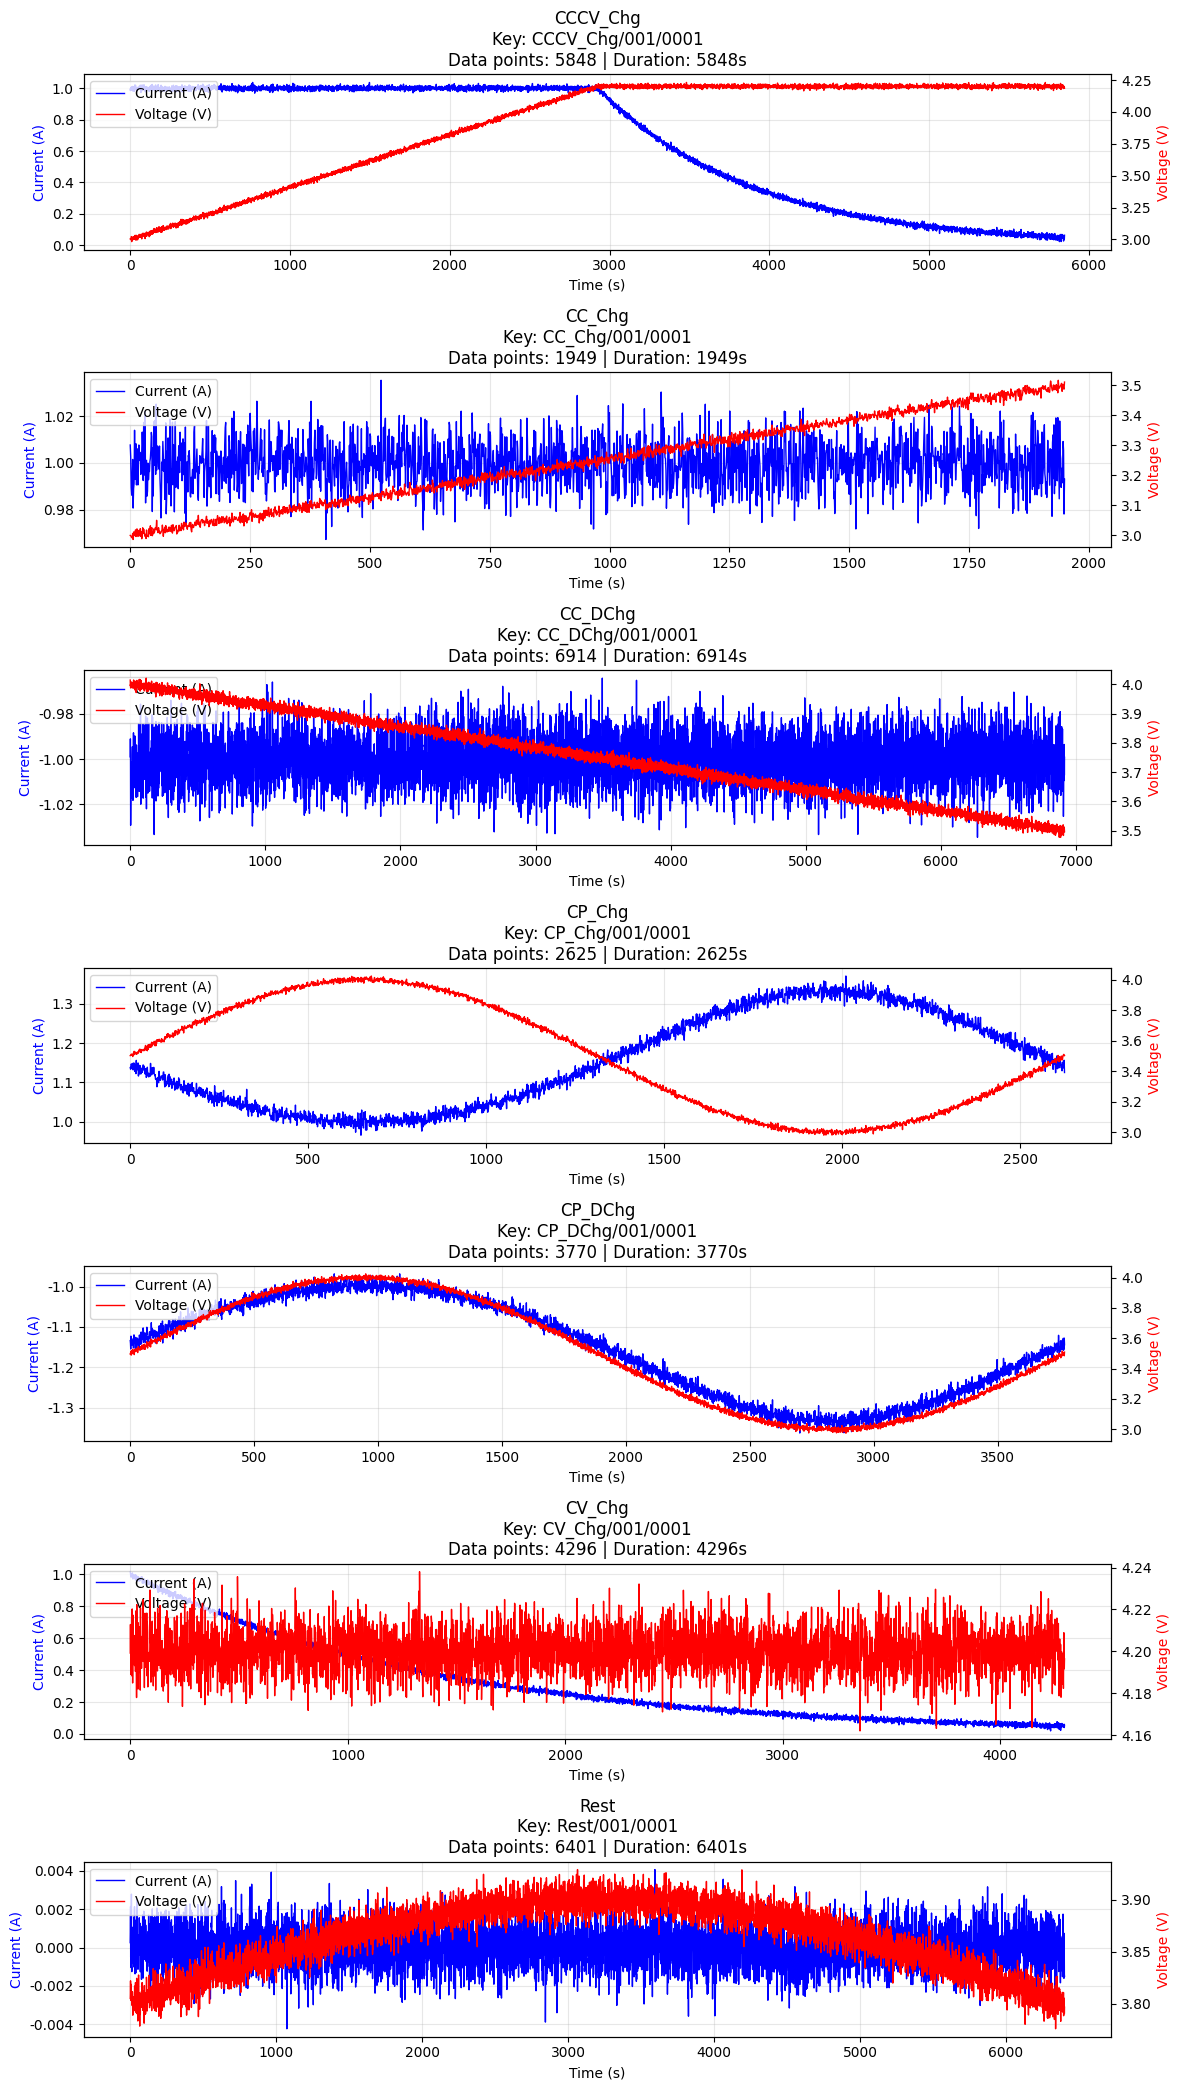


可视化了 7 种不同的步骤类型
每种类型展示了一个代表性样本


In [11]:
# 从不同步骤类型中各取一个样本进行可视化
def get_samples_for_visualization(env, max_samples_per_type=1):
    """获取用于可视化的样本"""
    samples = {}
    
    with env.begin() as txn:
        cursor = txn.cursor()
        
        for key, value in cursor:
            key_str = key.decode('utf-8')
            data = pickle.loads(value)
            step_name = data['step_name']
            
            # 如果还没有这个步骤类型的样本，或者样本数量不足
            if step_name not in samples:
                samples[step_name] = []
            
            if len(samples[step_name]) < max_samples_per_type:
                samples[step_name].append((key_str, data))
            
            # 检查是否收集齐了所有类型的样本
            if all(len(samples.get(st, [])) >= max_samples_per_type for st in STEP_TYPES.keys()):
                break
    
    return samples

# 获取样本数据
visualization_samples = get_samples_for_visualization(env)

# 绘制时间序列图
fig, axes = plt.subplots(len(visualization_samples), 1, figsize=(12, 3 * len(visualization_samples)))
if len(visualization_samples) == 1:
    axes = [axes]

for i, (step_name, samples) in enumerate(visualization_samples.items()):
    if not samples:
        continue
        
    key_str, data = samples[0]  # 取第一个样本
    ax = axes[i]
    
    # 绘制电流和电压随时间的变化
    ax2 = ax.twinx()
    
    line1 = ax.plot(data['t_data'], data['i_data'], 'b-', label='Current (A)', linewidth=1)
    line2 = ax2.plot(data['t_data'], data['v_data'], 'r-', label='Voltage (V)', linewidth=1)
    
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Current (A)', color='b')
    ax2.set_ylabel('Voltage (V)', color='r')
    
    step_type_cn = STEP_TYPES.get(step_name, step_name)
    ax.set_title(f'{step_name}\nKey: {key_str}\nData points: {len(data["t_data"])} | Duration: {data["metadata"]["duration"]}s')
    
    # 合并图例
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc='upper left')
    
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n可视化了 {len(visualization_samples)} 种不同的步骤类型")
print("每种类型展示了一个代表性样本")

## 12. 数据更新和删除

学习如何更新和删除数据库中的记录。

In [12]:
# 更新记录
def update_record(env, key, new_data):
    """更新记录"""
    with env.begin(write=True) as txn:
        # 检查记录是否存在
        if txn.get(key.encode('utf-8')):
            # 序列化新数据
            serialized_data = pickle.dumps(new_data)
            
            # 更新记录
            success = txn.put(key.encode('utf-8'), serialized_data)
            return success
        else:
            print(f"记录不存在: {key}")
            return False

# 删除记录
def delete_record(env, key):
    """删除记录"""
    with env.begin(write=True) as txn:
        success = txn.delete(key.encode('utf-8'))
        return success

# 批量删除
def batch_delete_by_prefix(env, prefix):
    """根据前缀批量删除记录"""
    keys_to_delete = []
    
    # 首先收集要删除的键
    with env.begin() as txn:
        cursor = txn.cursor()
        
        if cursor.set_range(prefix.encode('utf-8')):
            for key, value in cursor:
                key_str = key.decode('utf-8')
                if key_str.startswith(prefix):
                    keys_to_delete.append(key_str)
                else:
                    break
    
    # 执行删除
    deleted_count = 0
    with env.begin(write=True) as txn:
        for key in keys_to_delete:
            if txn.delete(key.encode('utf-8')):
                deleted_count += 1
    
    return deleted_count

# 演示更新操作
if keys:
    # 获取第一个记录
    target_key = keys[0]
    original_record = get_record_by_key(env, target_key)
    
    if original_record:
        print(f"原始记录: {target_key}")
        print(f"  原始持续时间: {original_record['metadata']['duration']} 秒")
        
        # 创建更新的记录
        updated_record = original_record.copy()
        updated_record['metadata']['duration'] = 7200  # 更新为2小时
        updated_record['metadata']['updated_at'] = datetime.datetime.now().isoformat()
        
        # 执行更新
        success = update_record(env, target_key, updated_record)
        
        if success:
            print(f"  更新成功!")
            
            # 验证更新
            updated_record_verify = get_record_by_key(env, target_key)
            print(f"  新的持续时间: {updated_record_verify['metadata']['duration']} 秒")
            print(f"  更新时间: {updated_record_verify['metadata']['updated_at']}")
        else:
            print(f"  更新失败!")

# 演示删除操作
print("\n删除操作演示:")

# 获取当前记录数
with env.begin() as txn:
    before_count = txn.stat()['entries']
    
print(f"删除前记录数: {before_count}")

# 删除一些CP_Chg类型的记录
deleted_count = batch_delete_by_prefix(env, "CP_Chg")
print(f"删除了 {deleted_count} 条CP_Chg记录")

# 检查删除后的记录数
with env.begin() as txn:
    after_count = txn.stat()['entries']
    
print(f"删除后记录数: {after_count}")
print(f"实际删除数量: {before_count - after_count}")

原始记录: CCCV_Chg/001/0001
  原始持续时间: 5848 秒
  更新成功!
  新的持续时间: 7200 秒
  更新时间: 2025-07-15T20:03:39.133240

删除操作演示:
删除前记录数: 195
删除了 15 条CP_Chg记录
删除后记录数: 180
实际删除数量: 15


## 13. 创建数据处理类

学习如何创建一个完整的数据处理类，封装所有LMDB操作。

In [13]:
class BatteryDataLMDB:
    """电池数据 LMDB 处理类"""
    
    def __init__(self, db_path, map_size=1024*1024*1024, readonly=False):
        self.db_path = db_path
        self.map_size = map_size
        self.readonly = readonly
        self.env = None
        
    def open(self):
        """打开数据库"""
        self.env = lmdb.open(self.db_path, 
                           map_size=self.map_size,
                           readonly=self.readonly,
                           max_dbs=1)
        return self.env
    
    def close(self):
        """关闭数据库"""
        if self.env:
            self.env.close()
            self.env = None
    
    def get_statistics(self):
        """获取数据库统计信息"""
        if not self.env:
            raise ValueError("数据库未打开")
            
        with self.env.begin() as txn:
            return txn.stat()
    
    def get_record(self, key):
        """获取单条记录"""
        if not self.env:
            raise ValueError("数据库未打开")
            
        with self.env.begin() as txn:
            value = txn.get(key.encode('utf-8'))
            if value:
                return pickle.loads(value)
            return None
    
    def put_record(self, key, data):
        """写入记录"""
        if not self.env:
            raise ValueError("数据库未打开")
            
        if self.readonly:
            raise ValueError("数据库为只读模式")
            
        with self.env.begin(write=True) as txn:
            serialized_data = pickle.dumps(data)
            return txn.put(key.encode('utf-8'), serialized_data)
    
    def delete_record(self, key):
        """删除记录"""
        if not self.env:
            raise ValueError("数据库未打开")
            
        if self.readonly:
            raise ValueError("数据库为只读模式")
            
        with self.env.begin(write=True) as txn:
            return txn.delete(key.encode('utf-8'))
    
    def query_by_prefix(self, prefix):
        """前缀查询"""
        if not self.env:
            raise ValueError("数据库未打开")
            
        results = []
        with self.env.begin() as txn:
            cursor = txn.cursor()
            
            if cursor.set_range(prefix.encode('utf-8')):
                for key, value in cursor:
                    key_str = key.decode('utf-8')
                    if key_str.startswith(prefix):
                        data = pickle.loads(value)
                        results.append((key_str, data))
                    else:
                        break
        
        return results
    
    def iterate_all(self, callback=None):
        """遍历所有记录"""
        if not self.env:
            raise ValueError("数据库未打开")
            
        with self.env.begin() as txn:
            cursor = txn.cursor()
            
            for key, value in cursor:
                key_str = key.decode('utf-8')
                data = pickle.loads(value)
                
                if callback:
                    callback(key_str, data)
                else:
                    yield key_str, data
    
    def __enter__(self):
        self.open()
        return self
    
    def __exit__(self, exc_type, exc_val, exc_tb):
        self.close()

# 使用数据处理类
print("演示数据处理类的使用:")

# 创建一个新的数据库实例
with BatteryDataLMDB(TUTORIAL_DB_PATH, readonly=True) as db:
    # 获取统计信息
    stats = db.get_statistics()
    print(f"总记录数: {stats['entries']:,}")
    
    # 查询CC_Chg类型的记录
    cc_chg_records = db.query_by_prefix("CC_Chg")
    print(f"CC_Chg记录数: {len(cc_chg_records)}")
    
    # 获取一个特定记录
    if cc_chg_records:
        key, data = cc_chg_records[0]
        print(f"示例记录: {key}")
        print(f"  步骤类型: {data['metadata']['step_type']}")
        print(f"  数据长度: {len(data['t_data'])}")
    
    # 统计各类型数量
    type_counts = Counter()
    for key, data in db.iterate_all():
        type_counts[data['step_name']] += 1
    
    print(f"\n类型统计:")
    for step_type, count in type_counts.most_common():
        print(f"  {step_type}: {count} 条")

print("\n数据处理类演示完成!")

演示数据处理类的使用:
总记录数: 180
CC_Chg记录数: 45
示例记录: CC_Chg/001/0001
  步骤类型: 恒流充电
  数据长度: 1949

类型统计:
  CC_Chg: 45 条
  CC_DChg: 45 条
  Rest: 45 条
  CCCV_Chg: 15 条
  CP_DChg: 15 条
  CV_Chg: 15 条

数据处理类演示完成!


## 14. 关闭数据库

学习如何正确关闭数据库连接。

In [14]:
# 关闭数据库连接
env.close()
print("数据库连接已关闭")

# 检查数据库文件
if os.path.exists(TUTORIAL_DB_PATH):
    db_size = sum(os.path.getsize(os.path.join(TUTORIAL_DB_PATH, f)) 
                 for f in os.listdir(TUTORIAL_DB_PATH) 
                 if os.path.isfile(os.path.join(TUTORIAL_DB_PATH, f)))
    print(f"数据库文件大小: {db_size / 1024 / 1024:.2f} MB")
    print(f"数据库文件位置: {TUTORIAL_DB_PATH}")
else:
    print("数据库文件不存在")

数据库连接已关闭
数据库文件大小: 20.67 MB
数据库文件位置: tutorial_battery_data.lmdb


## 15. 教程总结

通过本教程，你已经学会了完整的 LMDB 数据库操作流程：

### 1. 数据库创建和管理
- 创建新的 LMDB 数据库
- 设置数据库参数（大小、模式等）
- 正确关闭数据库连接

### 2. 数据写入操作
- 单条记录写入
- 批量数据写入
- 事务管理和错误处理
- 数据序列化（pickle）

### 3. 键值结构设计
- 设计合理的键值结构
- 支持前缀查询的层次化键
- 键的唯一性和可排序性
- 不同查询需求的键结构选择

### 4. 数据读取操作
- 按键精确查找
- 前缀查询和范围查询
- 数据库遍历和迭代
- 数据反序列化

### 5. 数据管理操作
- 更新现有记录
- 删除记录
- 批量删除操作
- 数据库统计和分析

### 6. 实际应用技巧
- 时间序列数据处理
- 数据可视化
- 封装完整的数据处理类
- 错误处理和异常管理

### 7. 最佳实践
- 使用事务确保数据一致性
- 批量操作提高效率
- 合理设计键值结构
- 正确管理数据库连接

### 生成的文件
- **教程数据库**: `/home/wyp/workbench/Data/lmdb_tutorial/tutorial_battery_data.lmdb`
- **包含数据**: 多种类型的电池测试步骤数据
- **数据结构**: 时间序列数据（时间、电流、电压）
- **键值结构**: `step_type/dataset_id/step_id` 格式

现在你已经掌握了 LMDB 数据库的完整使用方法，可以将这些知识应用到自己的项目中，进行高效的数据存储和检索！